In [6]:
from hardware_efficient import *
import matplotlib.pyplot as plt
from qiskit.aqua.operators import X, Y, Z, I

In [5]:
n=4
circuit=get_circuit(n=n,depth=2,Imaginary=True)
circuit.draw()

┌───┐┌───┐ ░ ┌────────────────┐ ░ ┌────────────────┐ ░ ┌───┐
anc_0: ┤ H ├┤ S ├─░─┤0               ├─░─┤0               ├─░─┤ H ├
       └───┘└───┘ ░ │                │ ░ │                │ ░ └───┘
  q_0: ───────────░─┤1               ├─░─┤1               ├─░──────
                  ░ │                │ ░ │                │ ░      
  q_1: ───────────░─┤2 2-qubit-PQC-1 ├─░─┤2 2-qubit-PQC-2 ├─░──────
                  ░ │                │ ░ │                │ ░      
  q_2: ───────────░─┤3               ├─░─┤3               ├─░──────
                  ░ │                │ ░ │                │ ░      
  q_3: ───────────░─┤4               ├─░─┤4               ├─░──────
                  ░ └────────────────┘ ░ └────────────────┘ ░

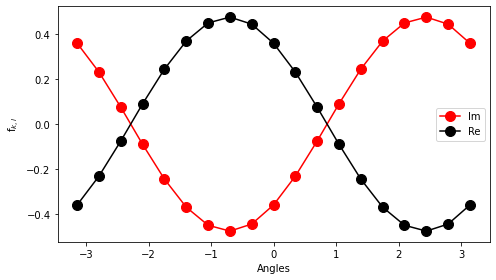

In [23]:
circuit_imag=get_circuit(n=n,depth=2,Imaginary=True)
circuit_real=get_circuit(n=n,depth=2,Imaginary=False)

vals_img=[]
vals_real=[]

A=np.linspace(-1*np.pi,1*np.pi,19)
angles=np.random.uniform(0,2*np.pi,len(circuit.parameters))
H1=Z^X^Y^Y^Y
H2=Z^X^Y^Y^Z
for i in A:
    np.put(angles,-1,i)
    vals_img.append(get_exp_angle(H1,circuit_imag,angles))
    vals_real.append(get_exp_angle(H2,circuit_real,angles))



fig,ax=plt.subplots(1,1,figsize=(7,4))
ax.plot(A,vals_img,marker="o",c="r",label="Im",markersize=10)
ax.plot(A,vals_real,marker="o",c="k",label="Re",markersize=10)
ax.set_ylabel("f$_{k,l}$")
ax.set_xlabel("Angles")
ax.legend()
plt.tight_layout()


In [102]:
from qiskit.quantum_info import Pauli

def Fl_theta(angles_k,angles_k_prev,tau,Ham,circuit_real):
    hl=Ham.coeff
    HI=Ham=PauliOp(Pauli.from_label("Z"+"I"*(circuit_real.num_qubits-1)),coeff=.4)
    angles=np.hstack((angles_k,angles_k_prev))
    if len(angles)!=len(circuit_real.parameters):
        raise Exception(f"Error len of angles {len(angles)} != len of parameters {len(circuit_real.parameters)}")
    return np.cosh(hl*tau)*get_exp_angle(HI,circuit_real,angles)-np.sinh(hl*tau)*get_exp_angle(Ham,circuit_real,angles)

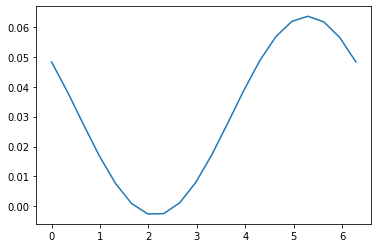

In [112]:
Ham=PauliOp(Pauli.from_label("ZXXYX"),coeff=.4)
angles_k=[1,1,1,1,1,1]
angles_k_prev=[1,1,1,1,1,1]
tau=.1
vals=[]
for i in np.linspace(0,2*np.pi,20):
    angles_k=[1,1,1,1,i,i]
    vals.append(Fl_theta(angles_k,angles_k_prev,tau,Ham,circuit))
plt.plot(np.linspace(0,2*np.pi,20),vals)

In [129]:
from scipy.optimize import minimize
from tqdm import tqdm_notebook as tqdm

circuit_real=get_circuit(n=n,depth=1,Imaginary=False)
circuit=get_circuit(n=n,depth=1,Imaginary=False,without_measure=True)

Ham=PauliOp(Pauli.from_label("ZXXYX"),coeff=.4)
angles_k=np.random.uniform(0,2*np.pi,int(len(circuit_real.parameters)/2))
angles_k_prev=np.random.uniform(0,2*np.pi,int(len(circuit_real.parameters)/2))
tau=.1

def func(angles_k,angles_k_prev):
    return -1*Fl_theta(angles_k,angles_k_prev,tau,Ham,circuit_real)

vals=[]
Energy=[]
for cnt in tqdm(range(50)):
    result=minimize(func, np.random.uniform(0,2*np.pi,len(angles_k)),method="SLSQP", args=(angles_k_prev))
    angles_k_prev=result.x
    vals.append(result.fun)
    Energy.append(get_exp_angle(Ham,circuit,angles_k_prev))

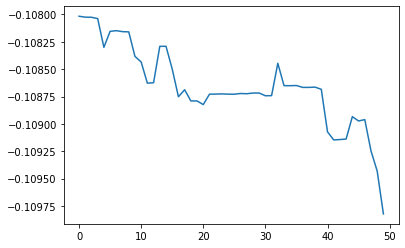

In [130]:
plt.plot(range(50),np.array(vals))